# Task 2 - Data Preprocessing & Model Building

## Prozess

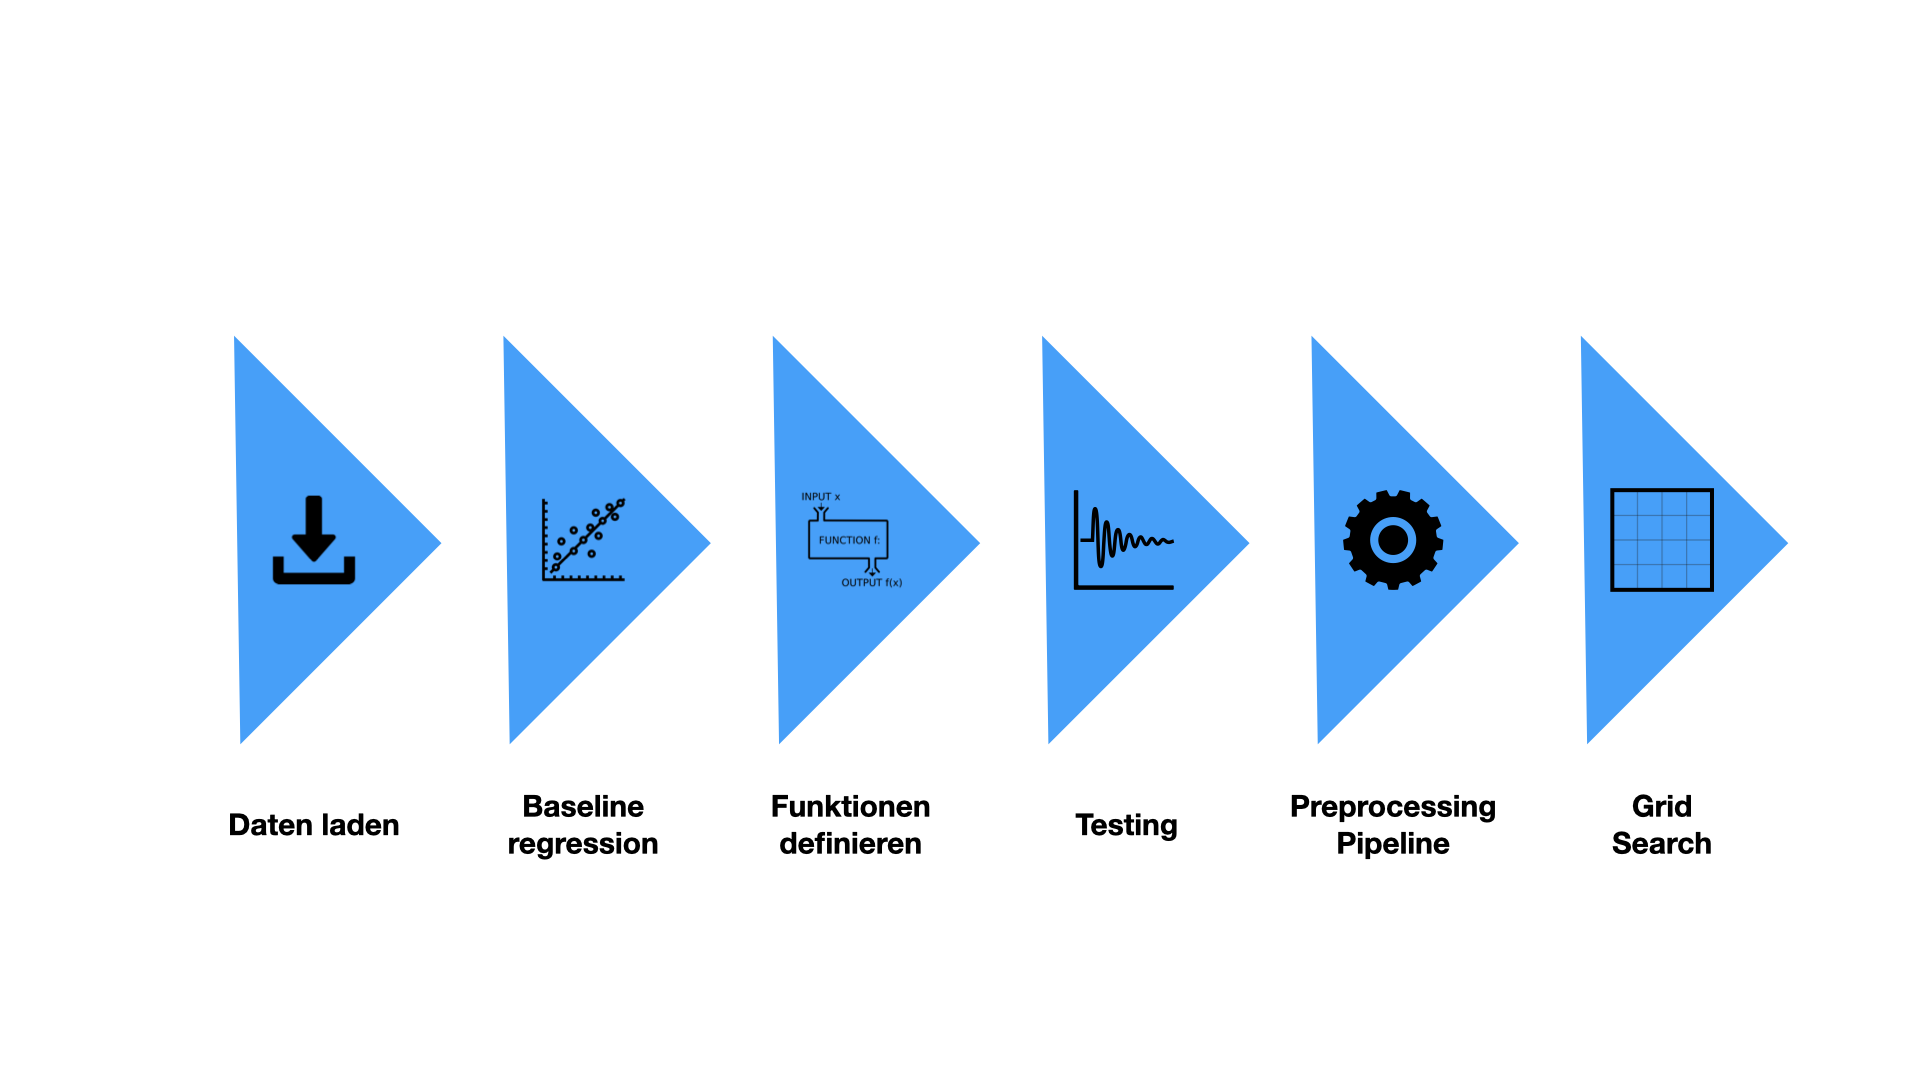

#Imports

In [ ]:
import io
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score
import datetime as dt
from time import time
from pprint import pprint
from sklearn.inspection import permutation_importance

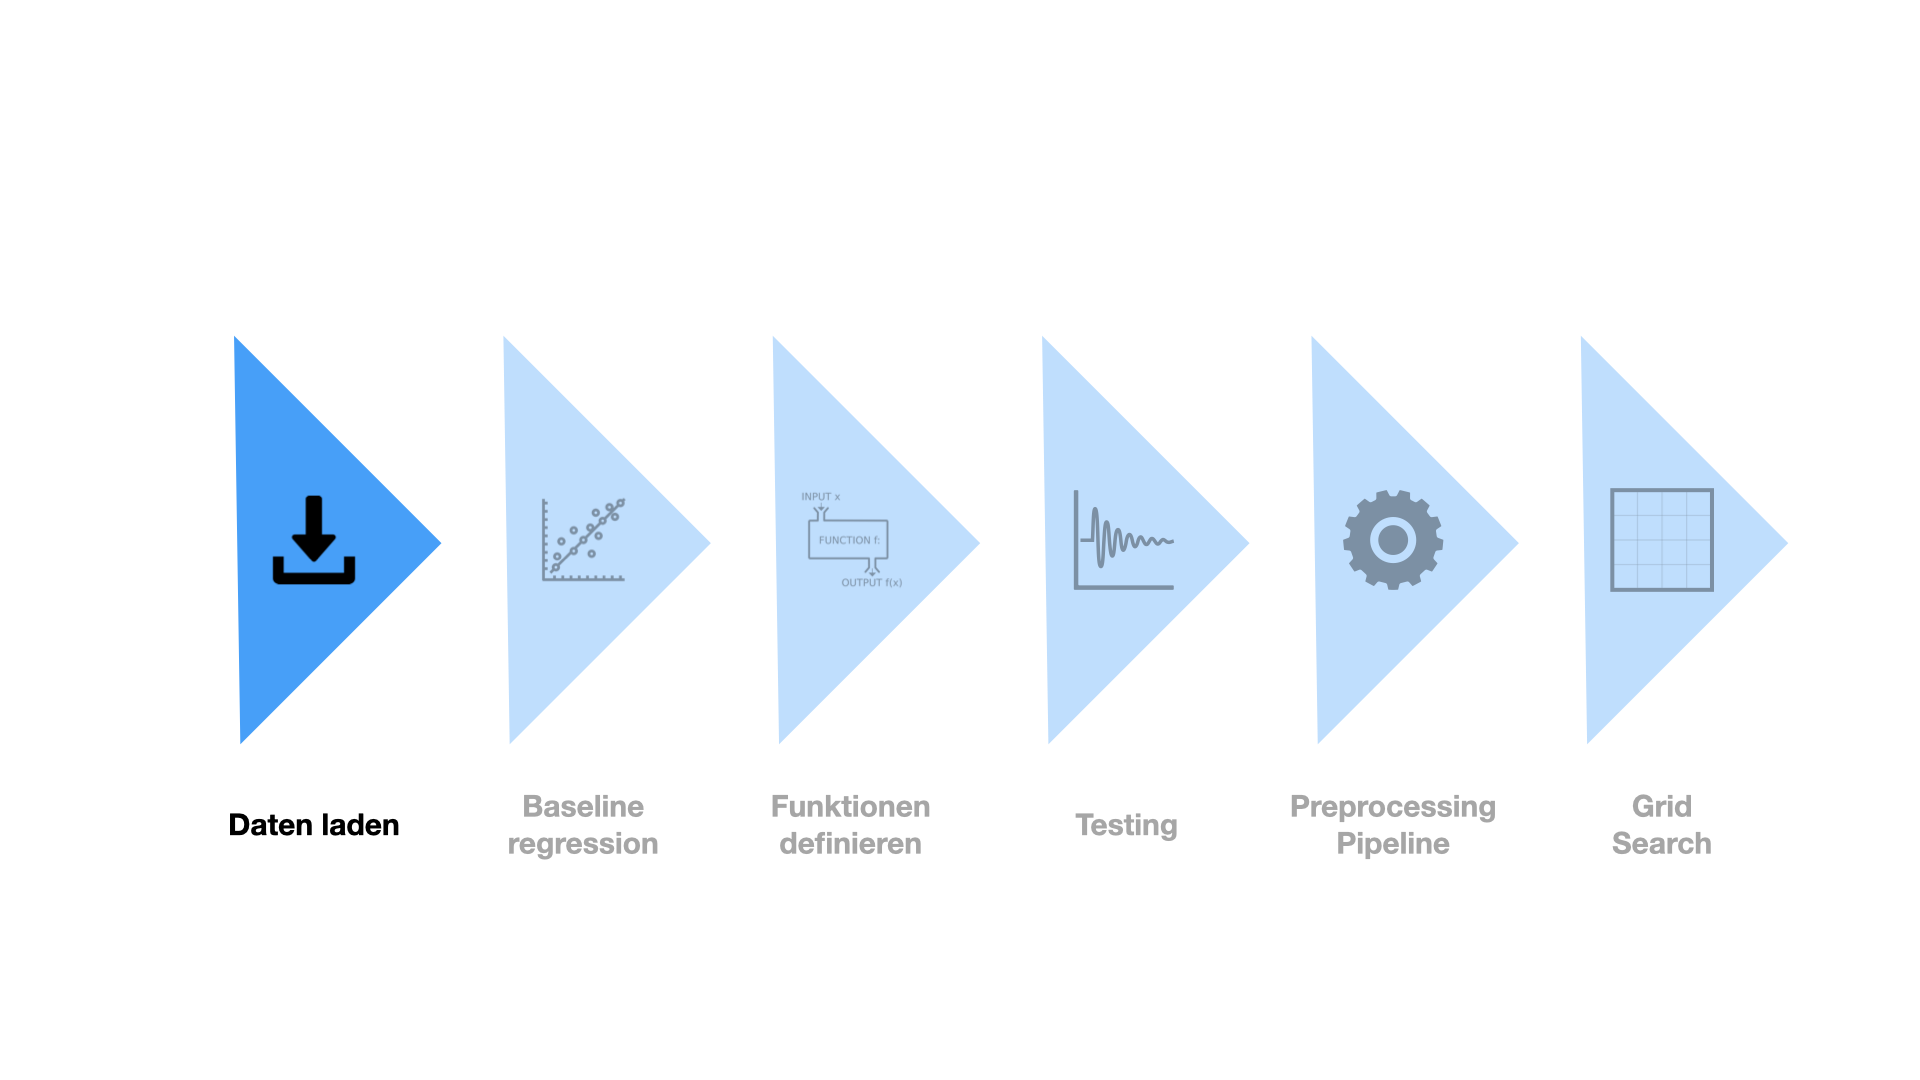

# Laden der Daten 
Die Daten werden aus einem CSV File in einen Pandas Dataframe geladen.
Besonderes Augenmerk muss hier auf den Zeitstempel gelegt werden:
Mit dem Formatstring **'%d.%m.%Y'** wird die integrität der Datumsspalte sichergestellt. Da wir für die Baseline regression auch den original Datensatz benötigen haben wir uns entschieden das Laden der Daten als Funktion zu formulieren.
Da die Datensätze eine unterschiedliche Datumsformatierung haben übergeben wir der Funktion einen String. Dieser gibt auskunft darüber ob es sich um den Originalen, den Aufbreiteten oder den gegebenen Datensatz handelt.

In [ ]:
Task1dfURL="https://raw.githubusercontent.com/leanderpeter/advanced-data-science-ss21-gruppe1/master/dataset_f_exploration.csv"
OriginaldfURL="https://raw.githubusercontent.com/kevin-eberhardt/advanced-data-science-ss21-gruppe1/main/data/BikeRentalDaily_train_valid.csv"
def load_data(url, ori):
  requested_file = requests.get(url).content
  decoded_file = io.StringIO(requested_file.decode('utf-8'))
  if ori == 'meth_ori':
    data = pd.read_csv(decoded_file, sep = ";")
    data["dteday"]= pd.to_datetime(data["dteday"], format='%d.%m.%Y')
  elif ori == 'exploration_clean':
    data = pd.read_csv(decoded_file, sep = ";")
    data["dteday"]= pd.to_datetime(data["dteday"], format='%Y.%m.%d')
  elif ori == '_ori':
    data = pd.read_csv(decoded_file, sep = ",")
    data["dteday"]= pd.to_datetime(data["dteday"], format='%Y-%m-%d')
  return data

original_df = load_data(OriginaldfURL, 'meth_ori')
cleaned_df = load_data(Task1dfURL, 'exploration_clean')

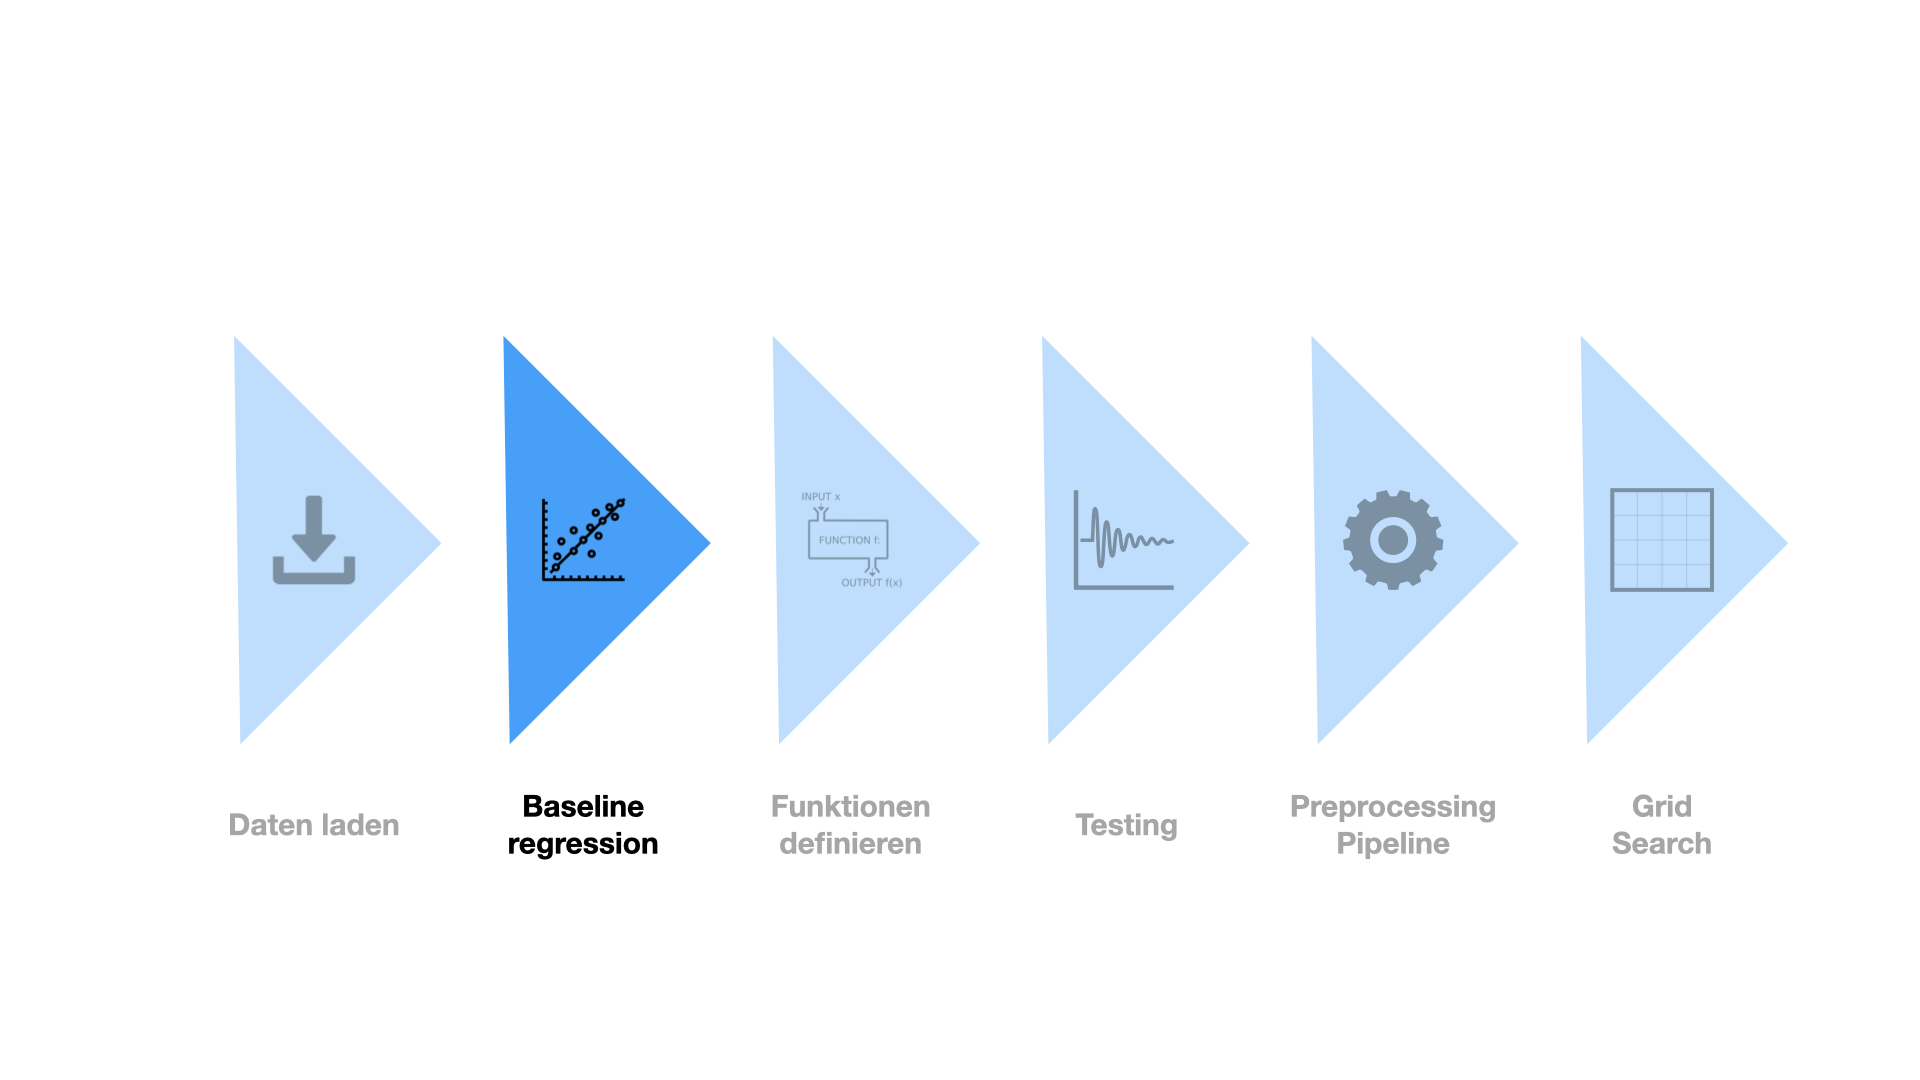

# Baseline regression

## Multiple feature regression

Um einen vergleichswert zu erhalten sowie das verständnis für die Daten zu erhöhen führen wir eine Baseline Regression durch. Hierbei bereiten wir den Datensatz minimal auf und geben ihn mit der Zielvariable in eine lineare Regression. Die minimale Regression erhält die variablen '**temp**', '**leaflets**', '**windspeed**','**season**', '**atemp**', '**hum**', **price** **reduction**, **yr**, **mnth**, **holiday**, **weekday**, **workingday**, **weathersit**,**price reduction**

In [ ]:
#  use all features for the baseline regression
ori_reg_df = original_df.dropna()
x = ori_reg_df[['temp', 'leaflets', 'windspeed','season', 'atemp', 'hum',"price reduction","yr","mnth","holiday","weekday","workingday","weathersit","price reduction"]]
y = ori_reg_df['cnt']

# split x and y into test and train
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.30 ,random_state = 2)

## baseline multiple features linear regression

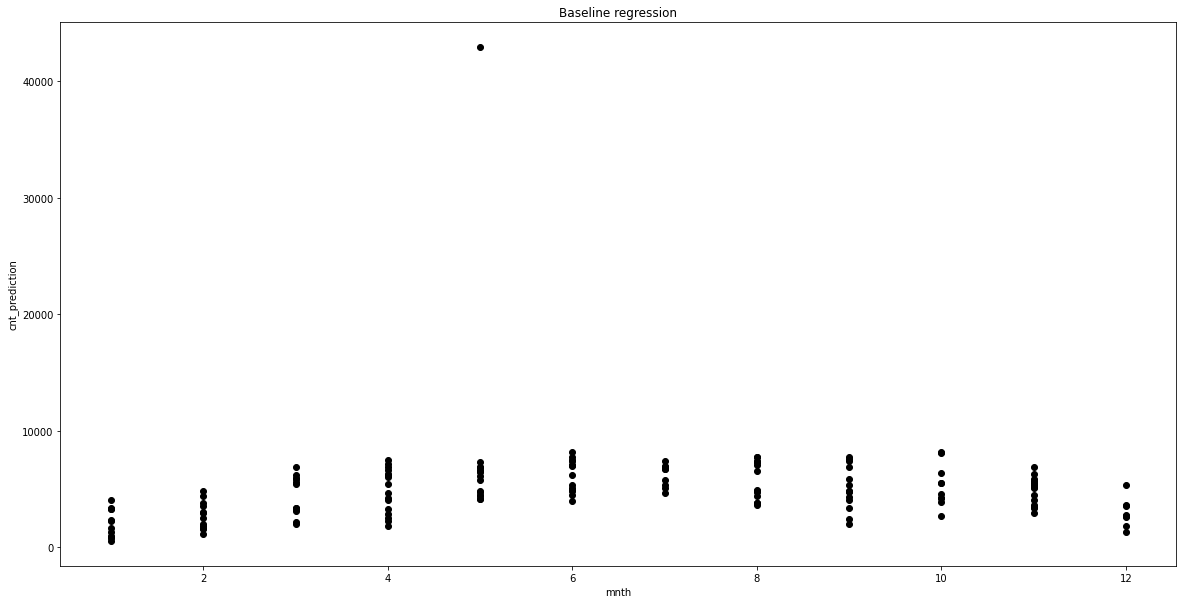

In [ ]:
clf_lr = LinearRegression()      
lr_baseline_model = clf_lr.fit(x_train,y_train)

def generate_accuracy_and_heatmap(model, x, y):
    pred = model.predict(x)
    return r2_score(y, pred)

generate_accuracy_and_heatmap(lr_baseline_model, x_test, y_test)

baseline_y_pred = lr_baseline_model.predict(x_test)
plt.figure(figsize=(20,10))
plt.scatter(x_test['mnth'], y_test,  color='black')
plt.title("Baseline regression")
plt.xlabel("mnth")
plt.ylabel("cnt_prediction")
plt.show()

Bei der Baseline Regression kommen wir auf einen **R² Wert von 0.322**. Dieser ist nicht zufriedenstellend und bietet möglichkeit der verbesserung. In der Grafik sind die, schon in der Data Exploration aufgefallenen, outlier zu sehen.

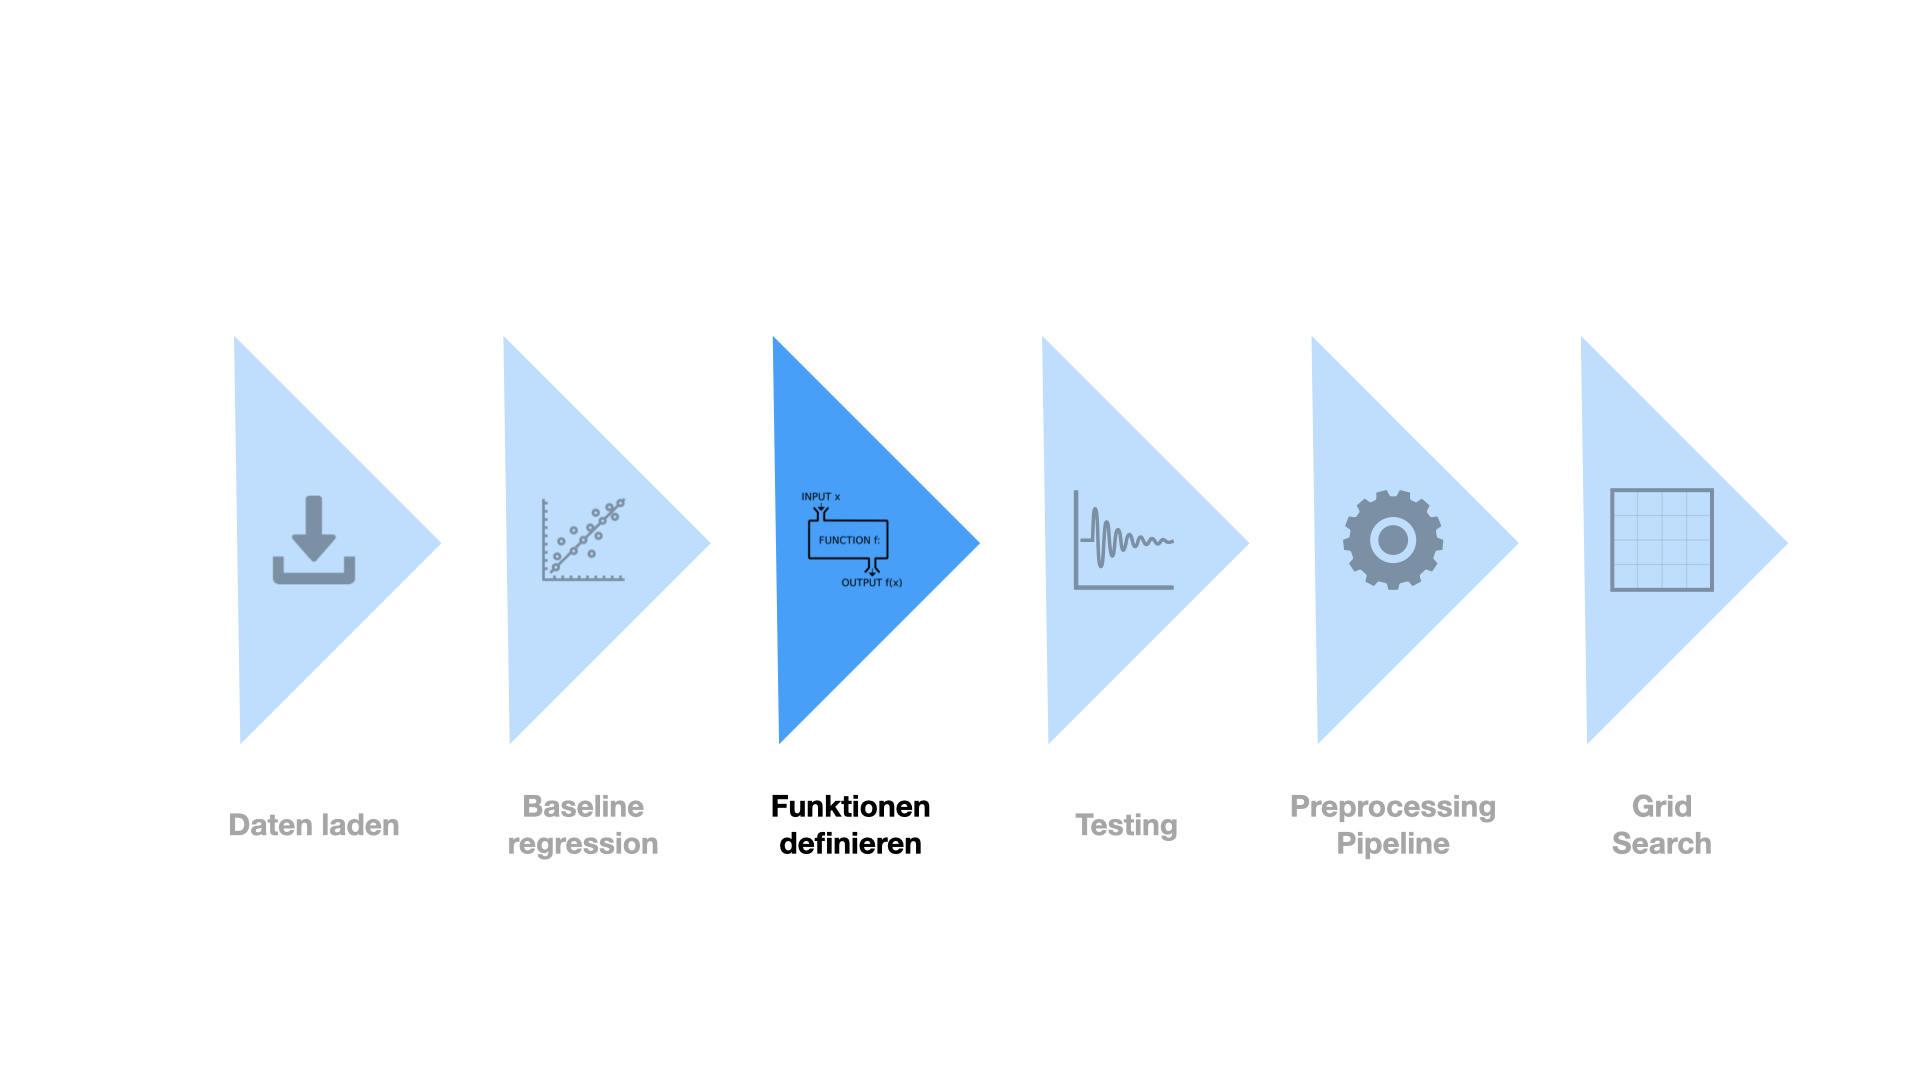

# Preprocessing Funktionen

## Data Preparing

Da unsere Test Daten aus einem unberührten Datensatz stammen müssen wir die Data Preparation Prozesse für weekday sowie season und date_offset auch in die Preprocessing Pipeline mit einbringen.

### Weekday Clean

In [ ]:
def weekday_clean(dataframe):
  dataframe['weekday_clean'] = dataframe['dteday'].dt.dayofweek
  return dataframe

### Season Clean

In [ ]:
def season_date_offset(dataframe):
  dataframe['date_offset'] = (dataframe.dteday.dt.month*100 + dataframe.dteday.dt.day - 320)%1300
  dataframe['season_clean'] = pd.cut(dataframe['date_offset'], [-1, 300, 602, 900, 1300], labels=[2, 3, 4, 1])
  return dataframe

## Drop unnecessary

Wir wissen bereits aus der Data Exploration das die Summe aus den Werten **casual** und **registered** unsere Zielvariable bildet. Somit werden wir diese Spalten entfernen.


---


Gleichzeitig wurde in der Data Exploration fehlende Werte in den Spalten season und weekday festgestellt. Somit entfernen wir nach der Imputation die Spalten **season** und **weekday** da diese später durch season_clean und weekday_clean ersetzt werden.


---

Wir verwenden für das Model die gefühlte Temperatur atemp da diese eine höheren informationsgehalt hat. Unsere Hypothese ist das Menschen sich beim Fahrrad mieten über die Gefühlte Temperatur beinflussen lassen, nicht durch die tatsächliche Temperatur. Somit kann auch **temp** entfernt werden.


---

Auch hat sich gezeigt das die Anzahl der **leaflets** über beide Jahre gleich verteilt ist. Diese kann somit auch entfernt werden.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Leaflets per season')

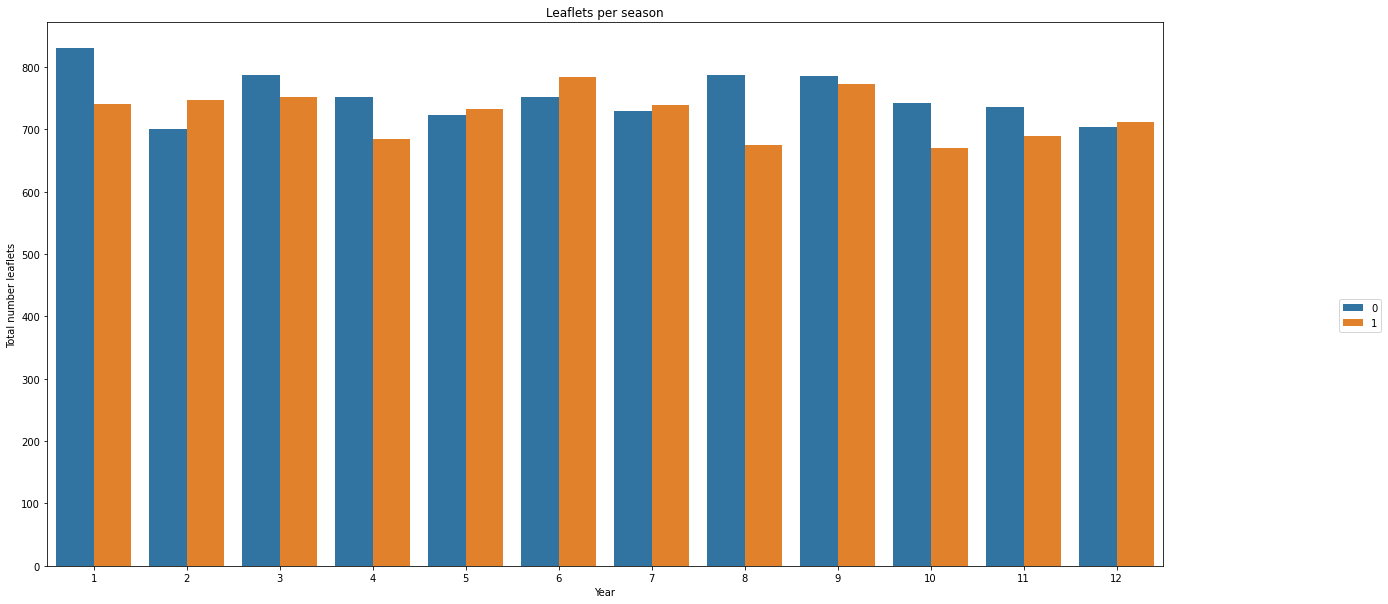

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot('mnth','leaflets',hue='yr', data=cleaned_df, ci=None)
plt.legend(loc='upper right',bbox_to_anchor=(1.2,0.5))
plt.xlabel('Months')
plt.ylabel('Total number leaflets')
plt.title('Leaflets per season')

In [ ]:
def remove_unnecessary(dataframe, columns):
  for cols in columns: 
    del dataframe[cols]
  return dataframe

#cleaned_df = remove_unnecessary(cleaned_df,['casual', 'registered', 'season', 'weekday', 'hum', 'temp', 'windspeed', 'instant', 'leaflets'])
#cleaned_df.head(10)

##Missing Values

Unsere Strategie besteht darin, aus der Spalte mit den fehlenden Werten neue Spalten zu erstellen und deren Auswirkung auf die Zielspalte zu überprüfen. Die schlechteren Spalten werden eliminiert und nur die nützlichen Spalten für die Schleife des maschinellen Lernens behalten.

Durch die Data Exploration in Task 1 wissen wir bereits das wir in den Spalten **season** und **hum** fehlende Werte haben. Um das zu überprüfen lassen wir uns erneut die fehlenden Werte anzeigen. 

---

Es ist zu anzumerken das wir ab diesem Abschnitt mit dem im Kurs erhaltenen 'präparierten' Datensatz arbeiten.

In [ ]:
original_df.isnull().sum()

instant             0
dteday              0
season             62
yr                  0
mnth                0
holiday             0
weekday             0
workingday          0
weathersit          0
temp                0
atemp               0
hum                34
windspeed           0
leaflets            0
price reduction     0
casual              0
registered          0
cnt                 0
dtype: int64

Zu erkennen ist das es sich um 62 fehlende season Werte sowie 34 fehlende hum Werte handelt. Hierbei ist besonders zu beachten das es sich bei season um ein Kategorische Featrue und bei hum um ein Numerisches Feature handelt.

## Imputation

Folgende Methoden der imputation wenden wir an:


1.   **Mean imputation**
2.   **Median imputation**
3.   **Constant imputation**
4.   **Avergae imputation with most frequent strategy**
5.   Deterministic Regression imputation
6.   Knn imputation

Wir definieren für die ersten 4 Strategien eine Funktion welche 3 parameter erwartet. Diese sind dataframe für den datensatz, column für die zu behandelnde Spalte sowie strategy welche die strategie bestimmt (mean, median, constant, most_frequent). Constant sollte hierbei nicht verwendet werden, da es für missing values eine 0 übergibt

### Simple Imputer


In [ ]:
from sklearn.impute import SimpleImputer

def unvariate_imputation(dataframe, column, strategy):
  imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
  clean_name = f"{column}_{strategy}_clean"
  dataframe[clean_name] = dataframe[column]
  dataframe[clean_name] = imp.fit_transform(dataframe[[clean_name]].to_numpy())
  return dataframe
  
# beispiel funktionsaufruf
# cleaned_df = unvariate_imputation(cleaned_df, 'hum', 'mean')




1.   Mean imputation
2.   Median imputation
3.   Constant imputation
4.   Avergae imputation with most frequent strategy
5.   **Deterministic Regression imputation**
6.   Knn imputation

Für die Determnistische Regression Imputation definieren wir eine Funktion welche 4 Parameter entgegennimmt. dataframe, welche den Datensatz darstellt, column für die zu behandelnde Spalte, refrence_column welche die X variable der Regression darstellt sowie iteration welche die Anzahl an Iterationen darstellt.

### Regression Imputer


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def regression_imputation(dataframe, column, refrence_column, iteration):
  clean_name = f"{column}_regression_with_{iteration}_clean"
  dataframe[clean_name] = dataframe[column]
  imp = IterativeImputer(max_iter=iteration, sample_posterior=False)
  dataframe[clean_name] = np.round(imp.fit_transform(dataframe[[clean_name, refrence_column]].to_numpy()),3)
  return dataframe

# beispiel funktionsaufruf
#cleaned_df = regression_imputation(cleaned_df, 'hum', 'temp', 100)
#cleaned_df.head(100)

1.   Mean imputation
2.   Median imputation
3.   Constant imputation
4.   Avergae imputation with most frequent strategy
5.   Deterministic Regression imputation
6.   **Knn imputation**

Für die Knn Imputation definieren wir eine Funktion welche 4 Parameter entgegennimmt. Dataframe, welche den Datensatz darstellt, column für die zu behandelnde Spalte, refrence_column welche die X variable der Knn darstellt sowie n welche die Anzahl an Nachbarn darstellt.

### Knn Imputer

In [ ]:
from sklearn.impute import KNNImputer

def knn_imputation(dataframe, column, refrence_column, n):
  clean_name = f"{column}_knn_clean"
  dataframe[clean_name] = dataframe[column]
  imputer = KNNImputer(n_neighbors=n, weights="uniform")
  dataframe[clean_name] = imputer.fit_transform(dataframe[[clean_name, refrence_column]].to_numpy())
  return dataframe

# beispiel funktionsaufruf
# cleaned_df = knn_imputation(cleaned_df, 'hum', 'temp', 2)
# cleaned_df.head(50)

1.   Mean imputation
2.   Median imputation
3.   Constant imputation
4.   Avergae imputation with most frequent strategy
5.   Deterministic Regression imputation
6.   Knn imputation
7.   **Random Forest Regressor**

Für die Knn Imputation definieren wir eine Funktion welche 4 Parameter entgegennimmt. Dataframe, welche den Datensatz darstellt, column für die zu behandelnde Spalte, refrence_column welche die X variable der Knn darstellt sowie n welche die Anzahl an Nachbarn darstellt.

## Random Forest Imputer

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_imputation(data, column, pred_columns):
  clean_name = f"{column}_random_forest_clean"
  data[clean_name] = data[column]
  if True in data.isnull()[column].unique():
    print('Outlier Found -- Starting imputation')
    hum_nans = data[data[clean_name].isnull()]
    hum_not_nan = data[data[clean_name].notnull()]
    hum_random_forest = RandomForestRegressor()
    hum_random_forest.fit(hum_not_nan[pred_columns], hum_not_nan[clean_name])
    hum_pred_values = hum_random_forest.predict(X= hum_nans[pred_columns])
    hum_nans[clean_name] = hum_pred_values
    data = hum_not_nan.append(hum_nans)
    data.reset_index(inplace=True)
    data.drop('index',inplace=True,axis=1)
    return data
  else:
    print('no outliers found')
    return data
  

#cleaned_df = random_forest_imputation(cleaned_df, 'hum', ["season_clean","weathersit","windspeed","mnth","temp","yr","atemp"])
#cleaned_df.head(50)

## Remove Wind Outliers

In dieser Funktion werden alle Windspeed Werte entfernt die einen Wert kleiner oder gleich 0 haben.

In [ ]:
def remove_wind_outliers(dataset, column):
  dataset[column] = dataset[column].apply(lambda x : x if x >= 0 else np.nan)
  return dataset

# cleaned_df = remove_wind_outliers(cleaned_df, 'windspeed')
# cleaned_df.head(10)

## Transformationen

Da wir in den Kategorischen Werte ordinal kodierte Wert haben müssen wir diese Transformieren. Wir wollen damit vermeiden das es z.B. bei der Spalte 'mnth' bei 1-12 zu einer ungewollten Wertung der Monate führt. Die Lösung ist die Verwendung von Encodern und glücklicherweise bietet SKLearn eine Vielzahl von Encodern. Eine detaillierte Liste der Encoder findet sich in der sklearn.preprocessing API, aber für unseren Fall verwenden wir den LabelBinarizer. Nach den Encodern werden wir auch die Normalisierer behandeln.


### LabelBinarizer

Der LabelBinarizer erweitert die Anzahl der Features in einem Datensatz, für jedes Label in der Spalte. Nach der Erweiterung wird das Label unter der Spalte als 1 und für den Rest als 0 angezeigt.
Wir definieren eine Funktion welche 2 Parameter entgegennimmt, dataframe für den Datensatz, sowie column für die Spalte welche bearbeitet werden soll. Die Funktion löscht nun die Spalte und fügt am Dataframe die hot encodeten spalten mit Name {column_hot-encoded-label} an.

In [ ]:
from sklearn.preprocessing import LabelBinarizer

def one_hot_encoder(dataframe, column):
  lb = LabelBinarizer()
  dataframe = dataframe.join(pd.DataFrame(lb.fit_transform(dataframe[column]),columns=lb.classes_, index=dataframe.index))
  uniques = dataframe[column].unique()
  col_names = {}
  for i in uniques:
    col_names[i] = f"{column}_{i}"
  dataframe = dataframe.rename(columns=col_names)
  return dataframe

# cleaned_df = one_hot_encoder(cleaned_df, 'holiday')
# cleaned_df.head(50)

## Outliers

Diese Funktion kümmert sich um Outlier. Sie entfernt einfach alles über dem 75. Quantil und unter dem 25. Quantil in einer angegebenen Spalte

In [ ]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

## Normalization
numerical_featuress = ["temp","atemp","hum","windspeed","leaflets"]

### MinMaxScaler

MinMax-Normierung wird verwendet, um alle Werte in den Bereich von 0 bis 1 zu bringen

In [ ]:
from sklearn import preprocessing

numerical_features = ["temp","atemp","hum","windspeed","leaflets"]

def min_max_scaler(dataframe, columns):
  min_max_scaler = preprocessing.MinMaxScaler()
  dataframe[columns] = min_max_scaler.fit_transform(dataframe[columns])
  return dataframe

# cleaned_df = min_max_scaler(cleaned_df, numerical_features)
# cleaned_df.head(50)

### Standard Scaler

StandardScaler transformiert Daten so, dass ihre Verteilung einen Mittelwert von 0 und eine Standardabweichung von 1 hat.

In [ ]:
from sklearn import preprocessing

def standard_scaler(dataframe, columns):
  standard_scaler = preprocessing.StandardScaler()
  dataframe[columns] = standard_scaler.fit_transform(dataframe[columns])
  return dataframe

#cleaned_df = standard_scaler(cleaned_df, numerical_features)
#cleaned_df.head(50)

###Robust Scaler

Wenn Daten viele Ausreißer enthalten, ist die Skalierung mit dem Mittelwert und der Standardabweichung oft nicht gut. In diesen Fällen entfernt RobustScaler den Median und skaliert die Daten entsprechend dem Quantilbereich.

In [ ]:
from sklearn import preprocessing

def robust_scaler(dataframe, columns):
  robust_scaler = preprocessing.RobustScaler()
  dataframe[columns] = robust_scaler.fit_transform(dataframe[columns])
  dataframe[columns] = robust_scaler.transform(dataframe[columns])
  return dataframe

# cleaned_df = robust_scaler(cleaned_df, numerical_features)
# cleaned_df.head(50)

###QuantileTransformer

QuantileTransformer wendet eine nichtlineare Transformation an, so dass die Wahrscheinlichkeitsdichtefunktion jedes Merkmals auf eine Gleichverteilung abgebildet wird. In diesem Fall werden alle Daten in den Bereich von 0 bis 1 abgebildet, auch die Ausreißer, die nicht mehr von den Normalwerten unterschieden werden können.

Wie RobustScaler ist QuantileTransformer robust gegenüber Ausreißern in dem Sinne, dass das Hinzufügen oder Entfernen von Ausreißern in der Trainingsmenge annähernd die gleiche Transformation auf den herausgehaltenen Daten ergibt. Aber im Gegensatz zu RobustScaler kollabiert QuantileTransformer auch automatisch jeden Ausreißer, indem er ihn auf die definierten Bereichsgrenzen (0 und 1) setzt.

Func takes in 3 args, column needs to be list

In [ ]:
from sklearn.preprocessing import QuantileTransformer

def quantile_transformer(dataframe, column, quantiles):
  # why the fuck did i added all transformed values to the dataframe?!
  # just replce them
  trans = QuantileTransformer(n_quantiles=quantiles, output_distribution='normal')
  data = trans.fit_transform(dataframe[column])
  # convert the array back to a dataframe
  dataframe[column] = data
  return dataframe

# cleaned_df = quantile_transformer(cleaned_df, ['temp'], 10)
# cleaned_df.head(10)

## Feature Selection

Das Ziel der rec_feature_eliminator funktion besteht darin, Features auszuwählen, indem rekursiv immer kleinere Sets von Features berücksichtigt werden. Zuerst wird der estimator auf dem anfänglichen Set von Features trainiert und die Wichtigkeit jedes Features wird entweder durch ein bestimmtes Attribut oder durch einen Callable ermittelt. Dann werden die am wenigsten wichtigen Merkmale aus dem aktuellen Satz von Merkmalen entfernt. Diese Prozedur wird rekursiv mit dem beschnittenen Satz wiederholt, bis die gewünschte Anzahl der auszuwählenden Merkmale schließlich erreicht ist.

###Rekursive feature elimination

In [ ]:
from sklearn.feature_selection import RFE

def rec_feature_elimination(dataframe, split, target, return_training_data, columns_consider):
  X = dataframe[columns_consider]
  Y = dataframe['cnt']
  x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=split, 
                                                    random_state=8)
  reg = linear_model.LinearRegression()
  reg.fit(x_train, y_train)
  rfe = RFE(estimator=reg, step=1)
  rfe = rfe.fit(x_train, y_train)
  selected_rfe_features = pd.DataFrame({'Feature':list(x_train.columns),'Ranking':rfe.ranking_})

  print('Optimal number of features :', rfe.n_features_)
  print('Best features :', x_train.columns[rfe.support_])

  if return_training_data:
    x_train_rfe = rfe.transform(x_train)
    x_test_rfe = rfe.transform(x_test)
    return x_train_rfe, x_test_rfe, y_train, y_test
  else:
    return selected_rfe_features

# ranking = rec_feature_elimination(cleaned_df, 0.3, 'cnt', False)
# ranking.sort_values(by='Ranking')

Die Funktion rec_feature_elimination_cv nimmt 4 Parameter entgegen. dataframe, der datensatz, cross die Anzahl an cross-folds, columns_consider die spalten welche für das training berücksichtigt werden sollen sowie split welches den faktor der aufteilung zwischen test und trainingsdatensatz angibt. Die funktion übernimmt das Feature-Ranking mit rekursiver Feature-Elimination und kreuzvalidierter Auswahl der besten Anzahl von Features.

### Rekursive feature elimination mit cross validation

In [ ]:
from sklearn.feature_selection import RFECV

def rec_feature_elimination_cv(dataframe, cross, columns_consider, split):
  X = dataframe[columns_consider]
  Y = dataframe['cnt']
  x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=split, 
                                                    random_state=8)
  reg = linear_model.LinearRegression()
  reg.fit(x_train, y_train)

  rfecv = RFECV(estimator=reg, step=1, cv=cross)
  rfecv = rfecv.fit(x_train, y_train)
  print('Optimal number of features :', rfecv.n_features_)
  print('Best features :', x_train.columns[rfecv.support_])
  '''
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score of number of selected features")
  plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
  plt.show()
  '''
  x_train_rfecv = rfecv.transform(x_train)
  x_test_rfecv = rfecv.transform(x_test)

  return x_train_rfecv, x_test_rfecv, y_train, y_test



### Univariate feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

def univariate_feature_selection(dataframe, columns_consider, split):
  X = dataframe[columns_consider]
  Y = dataframe['cnt']
  x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=split, 
                                                    random_state=8)
  select_feature = SelectKBest(chi2, k=5).fit(x_train, y_train)
  #selected_features_df = pd.DataFrame({'Feature':list(x_train.columns),'Scores':select_feature.scores_})
  #selected_features_df.sort_values(by='Scores', ascending=False)
  x_train_chi = select_feature.transform(x_train)
  x_test_chi = select_feature.transform(x_test)
  return x_train_chi, x_test_chi, y_train, y_test


# x_train_chi, x_test_chi, y_train, y_test = univariate_feature_selection(cleaned_df, cols_to_consider, 0.3)

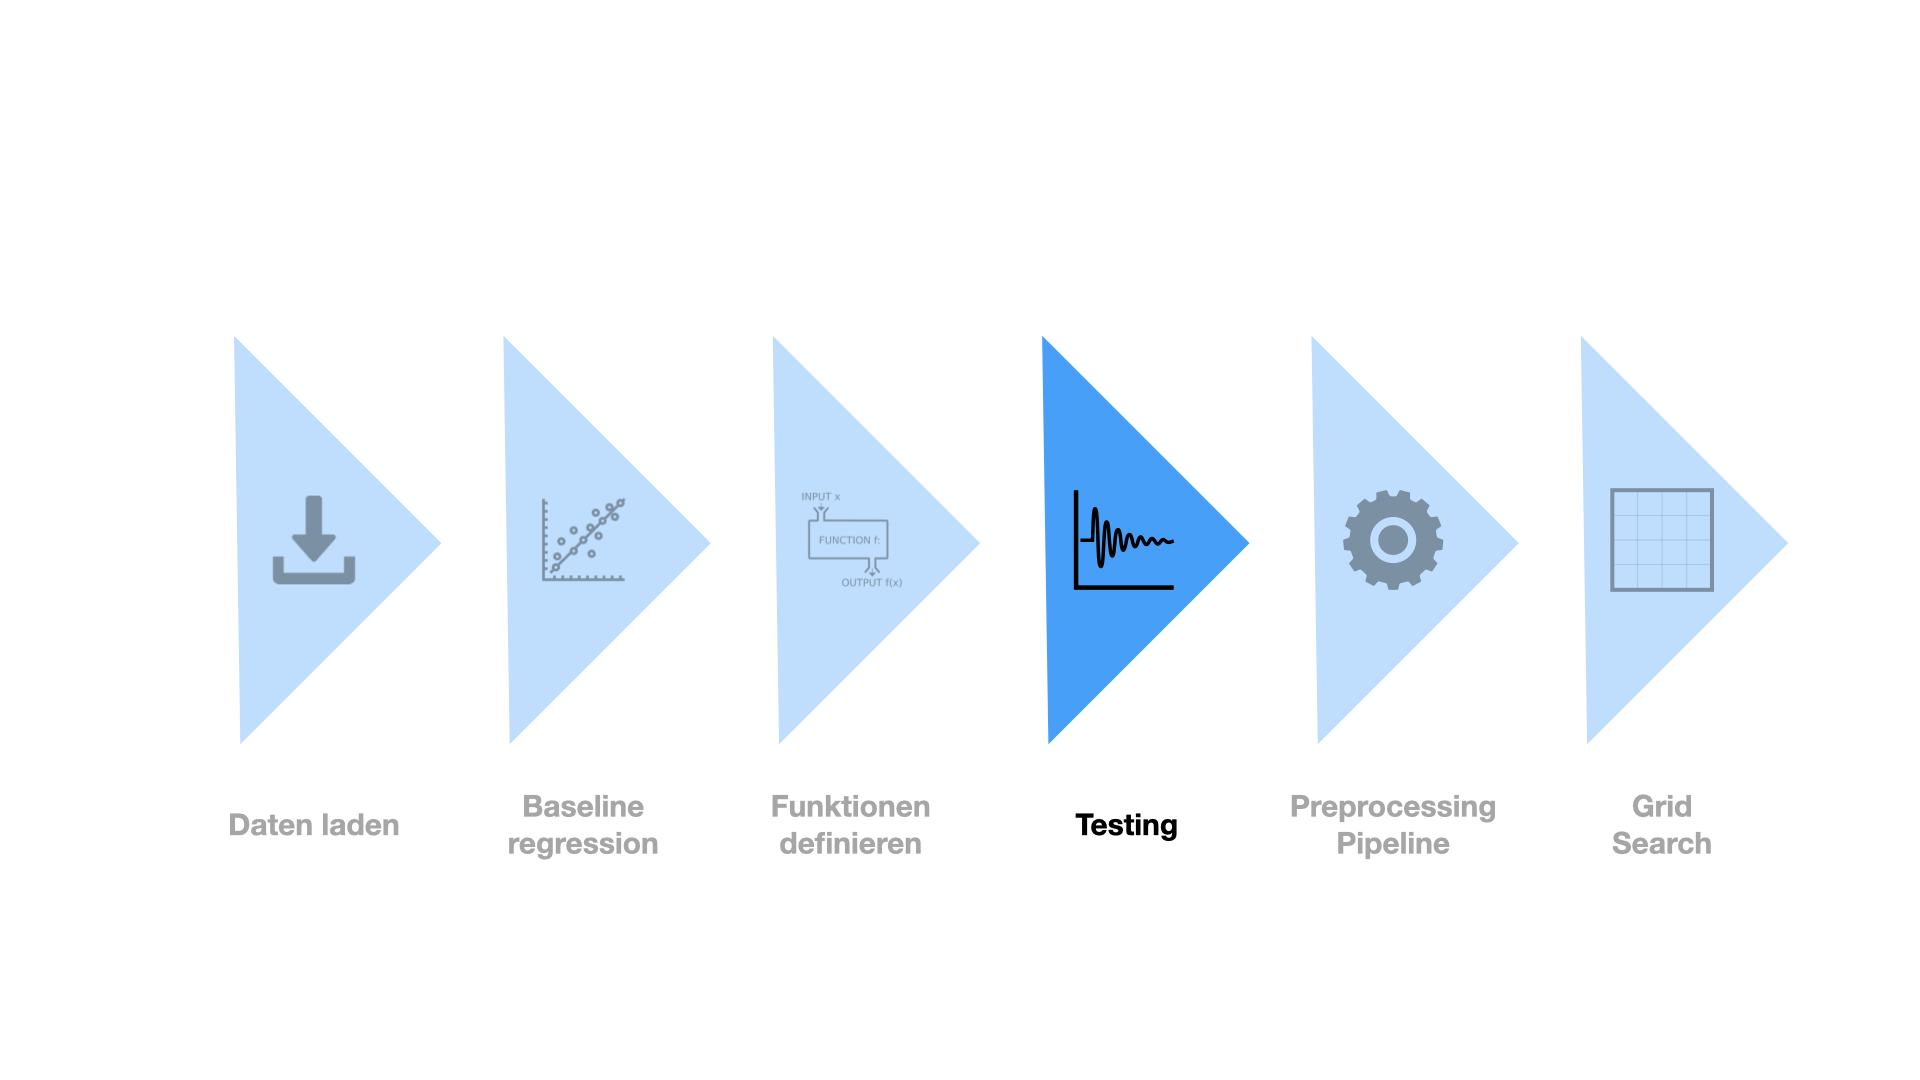

Hier klopfen wir nur das Preprocessing in einer test funktion zusammen und schauen wie sich unsere Werte bisher verbessern (oder verschlechtern).


---


Hierbei haben wir die verschiedenen Methode, recursive feature elimination und recursive feature elimination with cross validation manuelle feature selection, gegeneinander antreten lassen. Hierbei war zu erkennen das beide Methoden das Ergebnis massgeblich verschlechtert haben.

# Testing Playground

Outlier Found -- Starting imputation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Outlier Found -- Starting imputation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Optimal number of features : 21
Best features : Index(['yr', 'holiday', 'weathersit', 'atemp', 'season_clean',
       'hum_mean_clean', 'hum_median_clean', 'hum_most_frequent_clean',
       'hum_regression_with_10_clean', 'hum_knn_clean',
       'hum_random_forest_clean', 'weathersit_2', 'weathersit_3', 'mnth_1',
       'mnth_2', 'mnth_7', 'mnth_9', 'mnth_11', 'mnth_12', 'season_clean_2',
       'weekday_clean_6'],
      dtype='object')
(417, 21)
REC elimination R^2:  0.80694465065209
Optimal number of features : 42
Best features : Index(['yr', 'mnth', 'holiday', 'workingday', 'weathersit', 'atemp',
       'windspeed_random_forest_clean', 'price reduction', 'season_clean',
       'weekday_clean', 'hum_mean_clean', 'hum_median_clean',
       'hum_most_frequent_clean', 'hum_regression_with_10_clean',
       'hum_knn_clean', 'hum_random_forest_clean', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8

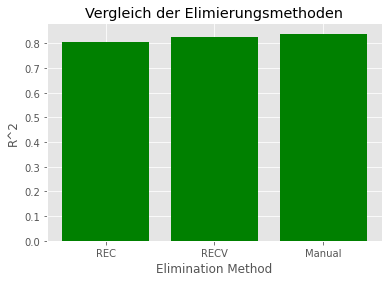

In [ ]:
# sample/shuffle dataframe
# cleaned_df = cleaned_df.sample(frac=1).reset_index(drop=True)

def preprocess(cleaned_df):
  #imputation
  cleaned_df = unvariate_imputation(cleaned_df, 'hum', 'mean')
  cleaned_df = unvariate_imputation(cleaned_df, 'hum', 'median')
  cleaned_df = unvariate_imputation(cleaned_df, 'hum', 'most_frequent')
  # regression imputer
  cleaned_df = regression_imputation(cleaned_df, 'hum', 'temp', 10)
  cleaned_df = knn_imputation(cleaned_df, 'hum', 'temp', 2)
  cleaned_df = random_forest_imputation(cleaned_df, 'hum', ["season_clean","weathersit","windspeed","mnth","temp","yr","atemp"])
  # wind outlier
  cleaned_df = remove_wind_outliers(cleaned_df, 'windspeed')
  #windspeed imputation 
  cleaned_df = random_forest_imputation(cleaned_df, 'windspeed', ["season_clean","weathersit","mnth","temp","yr","atemp"])
  # encoding
  cleaned_df = one_hot_encoder(cleaned_df, 'weathersit')
  cleaned_df = one_hot_encoder(cleaned_df, 'mnth')
  cleaned_df = one_hot_encoder(cleaned_df, 'season_clean')
  cleaned_df = one_hot_encoder(cleaned_df, 'weekday_clean')

  # die Spalten price reduction, workingday und holiday sind bereits
  # binaere daten. Somit ist ein one hot encoding nicht notwendig
      # cleaned_df = one_hot_encoder(cleaned_df, 'price reduction')
      # cleaned_df = one_hot_encoder(cleaned_df, 'workingday')
      # cleaned_df = one_hot_encoder(cleaned_df, 'holiday')

  # drop all unnecessary values
  cleaned_df = remove_unnecessary(cleaned_df,['casual', 'registered', 'season', 'weekday', 'hum', 'temp', 'windspeed', 'instant', 'leaflets'])

  #normalization
  numerical_features = ["atemp", 'windspeed_random_forest_clean', 'hum_mean_clean', 'hum_median_clean', 'hum_most_frequent_clean',
       'hum_regression_with_10_clean', 'hum_knn_clean',
       'hum_random_forest_clean']
  # cleaned_df = min_max_scaler(cleaned_df, numerical_features)
  # cleaned_df = standard_scaler(cleaned_df, numerical_features)
  cleaned_df = robust_scaler(cleaned_df, numerical_features)

  for i in range(len(numerical_features)):
    pass
    # cleaned_df = quantile_transformer(cleaned_df, [numerical_features[i]], 15)
  return cleaned_df

cleaned_df = preprocess(cleaned_df)

cols_to_consider = ['yr', 'mnth', 'holiday','workingday', 'weathersit', 'atemp',
       'windspeed_random_forest_clean', 'price reduction', 'date_offset', 'season_clean', 
       'weekday_clean', 'hum_mean_clean',
       'hum_median_clean', 'hum_most_frequent_clean',
       'hum_regression_with_10_clean', 'hum_knn_clean',
       'hum_random_forest_clean', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'season_clean_1', 'season_clean_2', 'season_clean_3', 'season_clean_4',
       'weekday_clean_0', 'weekday_clean_1', 'weekday_clean_2',
       'weekday_clean_3', 'weekday_clean_4', 'weekday_clean_5',
       'weekday_clean_6'] 



cols_to_consider_manual = ['yr', 'holiday', 'workingday', 'atemp',
       'windspeed_random_forest_clean', 'price reduction', 'date_offset',  
       'weekday_clean','hum_random_forest_clean', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'season_clean_1', 'season_clean_2', 'season_clean_3', 'season_clean_4'
       ]


def testpipeline_rec(cleaned_df, cols_to_consider, clf_lr):
  x_train_rfe, x_test_rfe, y_train_rfe, y_test_rfe = rec_feature_elimination(cleaned_df, 0.3, 'cnt', True, cols_to_consider)
  print(x_train_rfe.shape)
  new_rfe_model = clf_lr.fit(x_train_rfe, y_train_rfe)
  return generate_accuracy_and_heatmap(new_rfe_model, x_test_rfe, y_test_rfe)

# ranking = rec_feature_elimination(cleaned_df, 0.3, 'cnt', False, cols_to_consider)
# ranking.sort_values(by='Ranking')

def testpipeline2_recv(cleaned_df, cols_to_consider, clf_lr):
  x_train_rfe, x_test_rfe, y_train_rfe, y_test_rfe = rec_feature_elimination_cv(cleaned_df, 5, cols_to_consider, 0.3)
  print(x_train_rfe.shape)
  new_rfe_model = clf_lr.fit(x_train_rfe, y_train_rfe)
  return generate_accuracy_and_heatmap(new_rfe_model, x_test_rfe, y_test_rfe)

def testpipeline3_chi_square(cleaned_df, cols_to_consider, clf_lr):
  x_train_chi, x_test_chi, y_train, y_test = univariate_feature_selection(cleaned_df, cols_to_consider, 0.3)
  print(x_train_rfe.shape)
  new_rfe_model = clf_lr.fit(x_train_rfe, y_train_rfe)
  return generate_accuracy_and_heatmap(new_rfe_model, x_test_rfe, y_test_rfe)

def test_without_method(cleaned_df, cols_to_consider):
  X = cleaned_df[cols_to_consider]
  y = cleaned_df['cnt']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

  reg = LinearRegression().fit(X_train, y_train)
  score_without = reg.score(X_test, y_test)

  return score_without


print("REC elimination R^2: ",testpipeline_rec(cleaned_df, cols_to_consider, clf_lr))
print("RECV elimination R^2: ",testpipeline2_recv(cleaned_df, cols_to_consider, clf_lr))
# print("Chi2 elimination R^2: ",testpipeline3_chi_square(cleaned_df, cols_to_consider, clf_lr))
print("Manual elimination R^2: ",test_without_method(cleaned_df, cols_to_consider_manual))

plt.style.use('ggplot')

x = ['REC', 'RECV', 'Manual']
vals = [testpipeline_rec(cleaned_df, cols_to_consider, clf_lr), testpipeline2_recv(cleaned_df, cols_to_consider, clf_lr), test_without_method(cleaned_df, cols_to_consider_manual)]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, vals, color='green')
plt.xlabel("Elimination Method")
plt.ylabel("R^2")
plt.title("Vergleich der Elimierungsmethoden")

plt.xticks(x_pos, x)

plt.show()

Aus den oberen Daten zeigt sich das unsere Manuelle feature selection keine Signifikant schlechteren Ergebnisse erzielt das **RFE** und **RFEV**

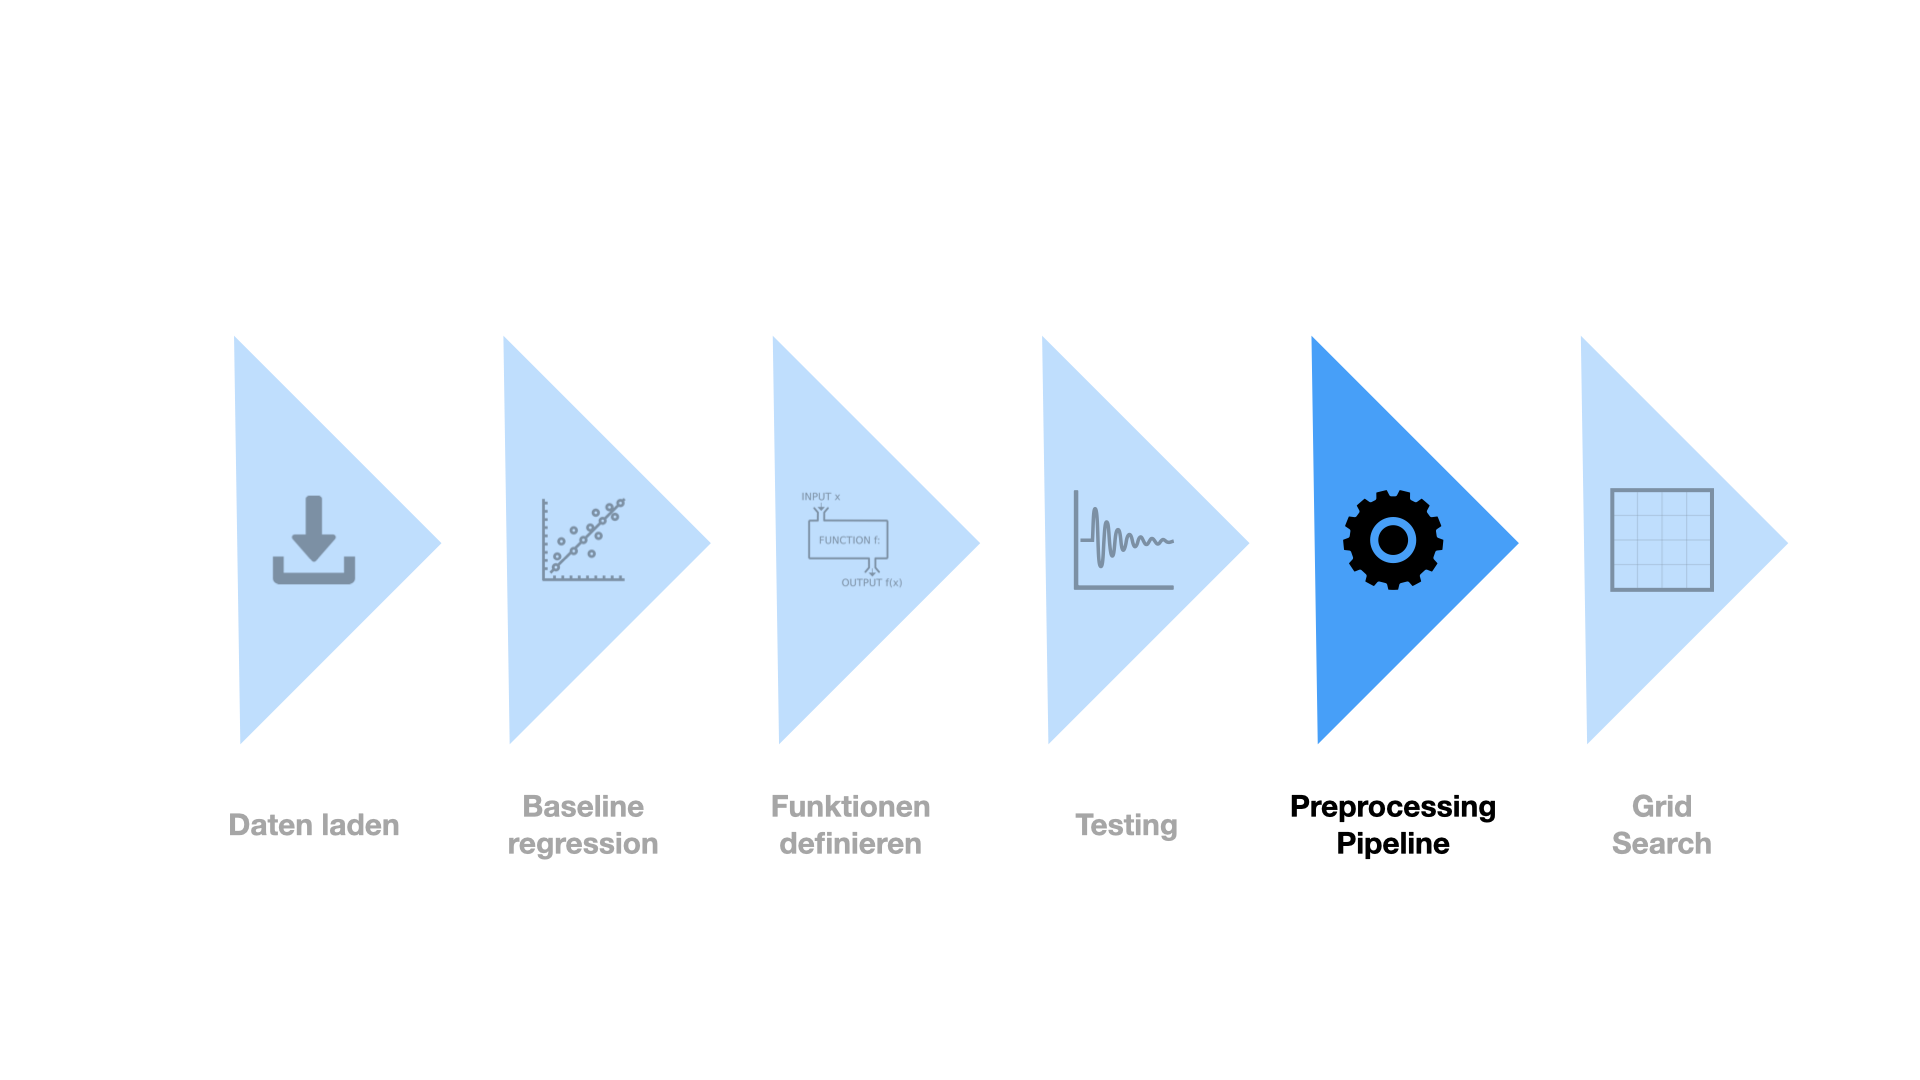

# Preprocessing Pipeline

In dieser Pipeline werden alle Daten verarbeitet. Die Pipeline ist darauf ausgelegt das wir auch "fremde" Daten vorverarbeiten können um mit diesen unser Model zu testen.


---

**Random Forest Imputation:**
Die Grundidee besteht darin, eine schnelle Ersetzung fehlender Daten vorzunehmen und dann iterativ die fehlende Imputation mithilfe von Proximity zu verbessern. Die Random-Forest-Imputation ist eine Technik die Nichtlinearitäten und Interaktionen berücksichtigen kann und nicht erfordert, dass ein bestimmtes Regressionsmodell angegeben wird. 


---


**MinMaxScaler:**
MinMaxScaler(feature_range = (0, 1)) transformiert jeden Wert in der Spalte proportional innerhalb des Bereichs [0,1]. Wir haben uns für den MinMaxScaler entschieden da wir die numerischen Werte im vorfeld von Outliern bereinigen.



In [ ]:
# cleaned_df.head(10)

In [ ]:
def preprocess_pipeline(dataframe, cols_to_consider):
  # weekday -> weekday_clean
  dataframe = weekday_clean(dataframe)
  # season -> season_clean + date_offset
  dataframe = season_date_offset(dataframe)
  # remove outliers (cnt)
  dataframe = remove_outlier(dataframe, 'cnt')
  # remove outliers (wind)
  dataframe = remove_wind_outliers(dataframe, 'windspeed')
  # random forest imputation (windspeed)
  dataframe = random_forest_imputation(dataframe, 'windspeed', ["season_clean","weathersit","mnth","atemp","yr"])
  # random forest imputation (hum)
  dataframe = random_forest_imputation(dataframe, 'hum', ["season_clean","weathersit","windspeed_random_forest_clean","mnth","atemp","yr"])
  # one hot encoding (weathersit)
  dataframe = one_hot_encoder(dataframe, 'weathersit')  
  # one hot encoding (mnth)
  dataframe = one_hot_encoder(dataframe, 'mnth')
  # one hot encoding (season_clean)
  dataframe = one_hot_encoder(dataframe, 'season_clean')
  # normalize min max scaler (all numeric values ?)
  numerical_features = ["atemp", 'windspeed_random_forest_clean', 'hum_random_forest_clean', 'date_offset', 'weekday_clean']
  dataframe = min_max_scaler(dataframe, numerical_features)
  # Split in X and y for training or testing

  X = dataframe[cols_to_consider]
  y = dataframe['cnt']
  return X, y

### Run the Pipeline

In [ ]:
cols_to_consider_manual = ['yr', 'holiday', 'workingday', 'atemp',
       'windspeed_random_forest_clean', 'date_offset',  
       'weekday_clean','hum_random_forest_clean', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'season_clean_1', 'season_clean_2', 'season_clean_3', 'season_clean_4']

X, y = preprocess_pipeline(original_df, cols_to_consider_manual)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Outlier Found -- Starting imputation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Outlier Found -- Starting imputation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



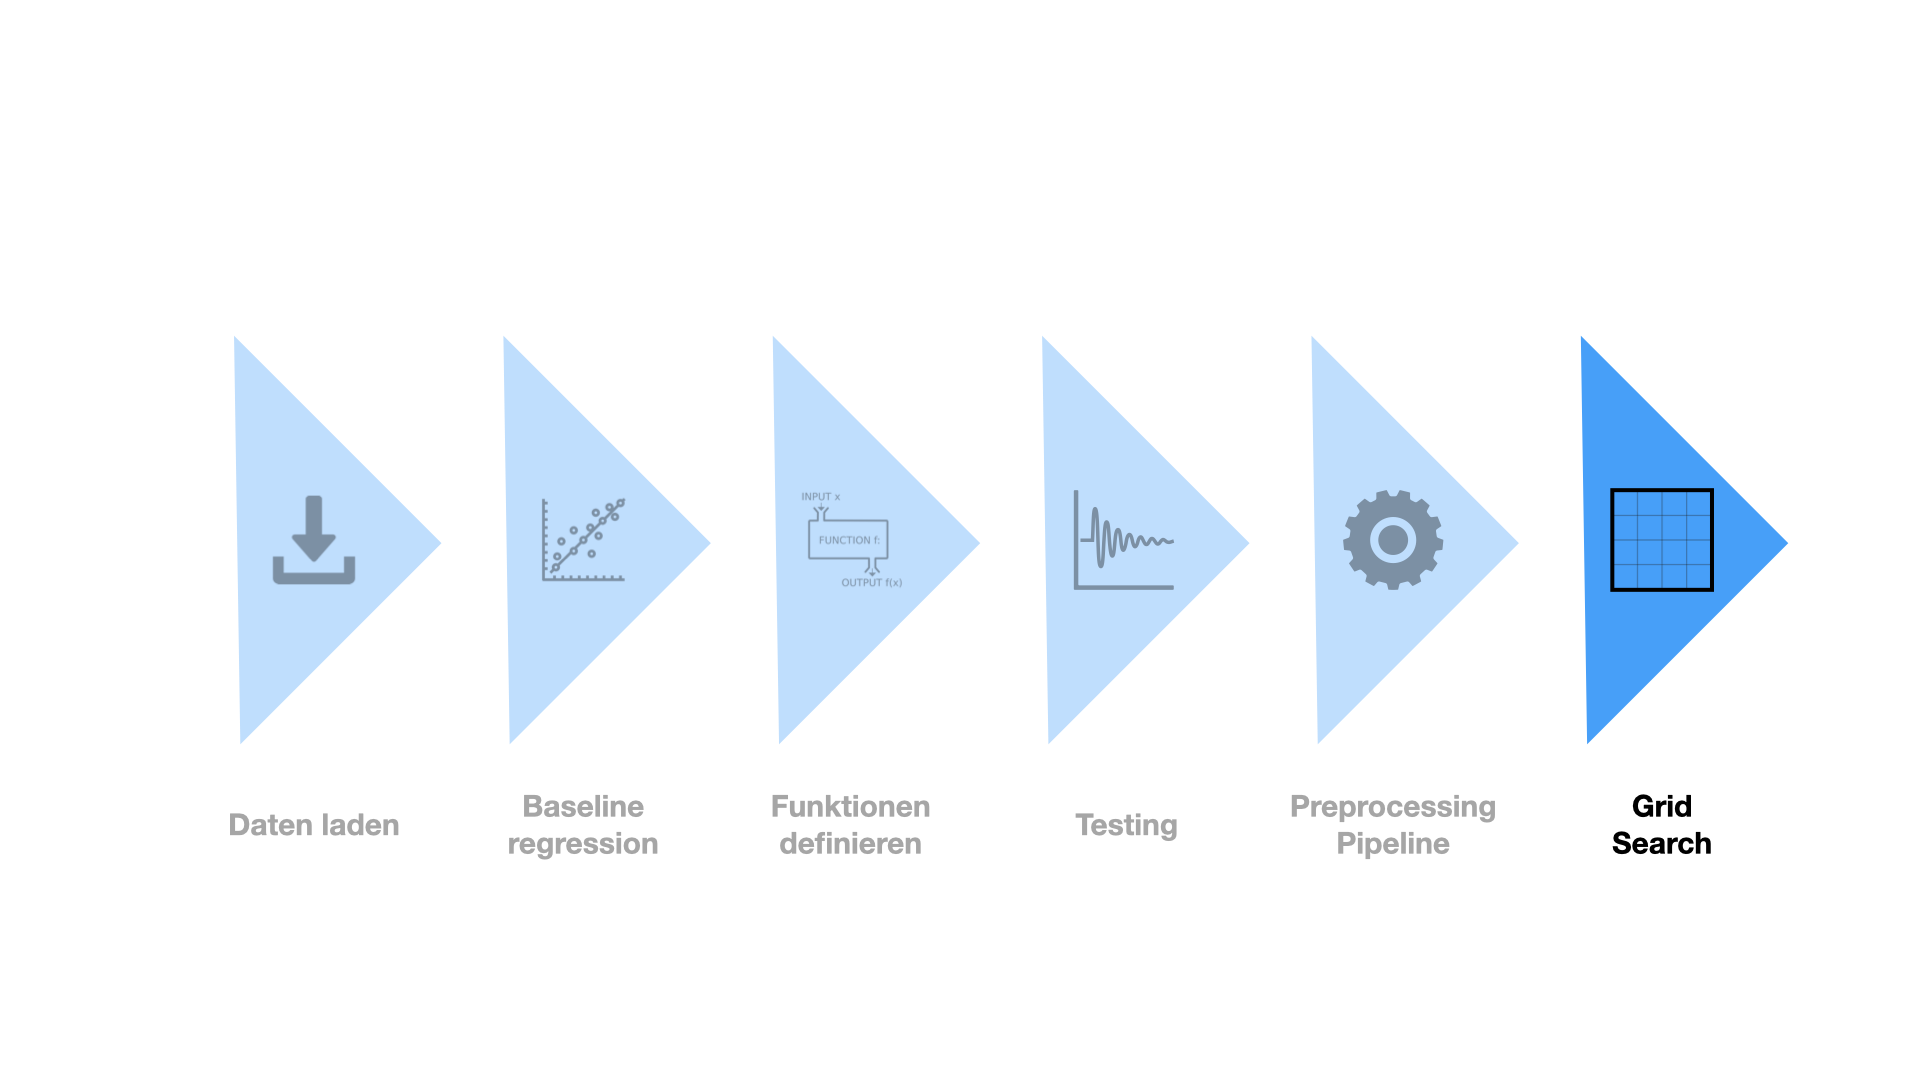

# Comparison of regression models

https://scikit-learn.org/stable/supervised_learning.html

Da wir einen kontinuirlichen Wert bestimmen wollen, nutzen wir die Regression. Dabei testen wir zunächst mit den Default Einstellungen folgende Regressoren. Dadurch können wir relativ schnell und vor allem Ressourcen schonend den Besten wählen.

In [ ]:
from sklearn import svm #Support Vector Machines
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge #Kernel ridge regression
from sklearn.neighbors import KNeighborsRegressor #Regression based on k-nearest neighbors
from sklearn.neighbors import RadiusNeighborsRegressor #Regression based on neighbors within a fixed radius
from sklearn.gaussian_process import GaussianProcessRegressor #Gaussian process regression
from sklearn.cross_decomposition import PLSRegression #PLS regression
from sklearn.tree import DecisionTreeRegressor #decision tree regressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.neural_network import MLPRegressor #Multi-layer Perceptron regressor


In [ ]:
names = [
         "LARS Lasso",
         "Bayesian regression",
         "SGD",
         "Kernel ridge regression",
         "Support Vector Machines",
         "KNeighborsRegressor",
         "RadiusNeighborsRegressor",
         "GaussianProcessRegressor",
         "PLSRegression",
         "DecisionTreeRegressor",
         "GradientBoostingRegressor",
         "RandomForestRegressor",
         "LinearRegression",
         "MLPRegressor"]

models = [
          linear_model.LassoLars(),
          linear_model.BayesianRidge(),
          linear_model.SGDRegressor(),
          KernelRidge(),
          svm.SVR(),
          KNeighborsRegressor(),
          RadiusNeighborsRegressor(),
          GaussianProcessRegressor(),
          PLSRegression(),
          DecisionTreeRegressor(),
          GradientBoostingRegressor(),
          RandomForestRegressor(),
          LinearRegression(),
          MLPRegressor(max_iter=10000)]

score = []
    


Wir iterieren über die verschiedenen Regressoren und lassen uns den R^2 Score ausgeben.

In [ ]:
for name, regr in zip(names, models):

    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    score.append(r2)
    print('**************')
    print(name)
    print('r2 score %s' % r2)
    print('**************')
    print()

**************
LARS Lasso
r2 score 0.8297651694129896
**************

**************
Bayesian regression
r2 score 0.8327757927052974
**************

**************
SGD
r2 score 0.8236352167554731
**************

**************
Kernel ridge regression
r2 score 0.8316902561854295
**************

**************
Support Vector Machines
r2 score -0.016116849808851752
**************

**************
KNeighborsRegressor
r2 score 0.6658362347104101
**************

**************
RadiusNeighborsRegressor
r2 score -2.555698766027991e+30
**************

**************
GaussianProcessRegressor
r2 score 0.7237386210102603
**************

**************
PLSRegression
r2 score 0.8124052452302456
**************

**************
DecisionTreeRegressor
r2 score 0.663090267220376
**************

**************
GradientBoostingRegressor
r2 score 0.8931933044468379
**************

**************
RandomForestRegressor
r2 score 0.8694452389040497
**************

**************
LinearRegression
r2 score 0.834771

In [ ]:
regr_scores = pd.DataFrame(np.column_stack([names, score]), 
                               columns=['Regression Model', 'R^2 Score'])

regr_scores


,Regression Model,R^2 Score
0,LARS Lasso,0.8297651694129896
1,Bayesian regression,0.8327757927052974
2,SGD,0.8236352167554731
3,Kernel ridge regression,0.8316902561854295
4,Support Vector Machines,-0.016116849808851752
5,KNeighborsRegressor,0.6658362347104101
6,RadiusNeighborsRegressor,-2.555698766027991e+30
7,GaussianProcessRegressor,0.7237386210102603
8,PLSRegression,0.8124052452302456
9,DecisionTreeRegressor,0.663090267220376


# And the winner is: GradientBoostingRegressor
---

Der r2-score von 0.8834170981898626 führt dazu das wir mit dem Gradient Boosting Regressor weiter arbeiten.

---

## Definition:
 
*GB baut ein additives Modell stufenweise vorwärts auf; es erlaubt die Optimierung beliebiger differenzierbarer Verlustfunktionen. In jeder Stufe wird ein Regressionsbaum an den negativen Gradienten der gegebenen Verlustfunktion angepasst.*

---
https://ichi.pro/de/was-ist-gradient-boosting-wie-unterscheidet-es-sich-von-ada-boost-45556808207053

"Gradient Boosting ist eine Art Boosting-Algorithmus. Es beruht auf der Intuition, dass das bestmögliche nächste Modell in Kombination mit früheren Modellen den Gesamtvorhersagefehler minimiert. Die Schlüsselidee besteht darin, die Zielergebnisse für dieses nächste Modell festzulegen, um den Fehler zu minimieren. Gradient Boosting kann sowohl für die Klassifizierung als auch für die Regression verwendet werden."

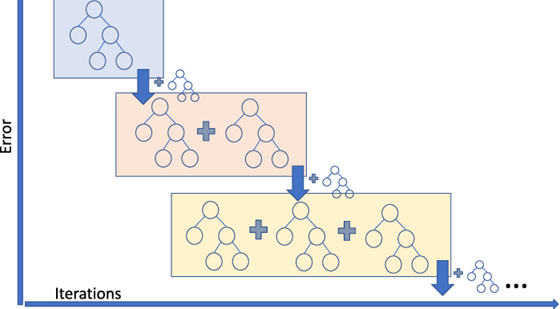

Mit der GridSearchCV drehen wir sozusagen an den Stellschrauben des Modells und probieren alle Möglichenkombinationen aus. 

Als Parameter haben wir die LearningRate, Subsample, n_estimators und max_depth. 

**Learningrate:**
Lernrate verkleinert den Beitrag jedes Baums um learning_rate

**Subsample:**
Der Anteil der Stichproben, der für die Anpassung der einzelnen Basis-Learner verwendet werden soll. Wenn er kleiner als 1,0 ist, führt dies zu Stochastic Gradient Boosting.

**N_Estimators:**
Die Anzahl der Boosting-Stufen, die durchgeführt werden. Gradient Boosting ist ziemlich robust gegenüber Overfitting, daher führt eine große Anzahl normalerweise zu einer besseren Leistung.

**Max_Depth:**
Maximale Tiefe der einzelnen Regressionsschätzer. Die maximale Tiefe begrenzt die Anzahl der Knoten im Baum. Stimmen Sie diesen Parameter für die beste Leistung ab; der beste Wert hängt von der Interaktion der Eingangsvariablen ab.

In [ ]:
from sklearn.model_selection import GridSearchCV
# define model
model = GradientBoostingRegressor()
# define evaluation
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['learning_rate'] = [0.01,0.02,0.03,0.04]
space['subsample'] = [0.9, 0.5, 0.2, 0.1]
space['n_estimators'] = [100,500,1000, 1500]
space['max_depth'] = [4,6,8,10]


if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    print("Performing grid search...")
    print("parameters:")
    pprint(space)
    t0 = time()
    # define search
    search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1)
    # execute search
    result = search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    y_pred = search.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print('Best R2 Score: ', r2)
    print("Best parameters set:")
    best_parameters = search.best_estimator_.get_params()
    for param_name in sorted(space.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))



Performing grid search...
parameters:
{'learning_rate': [0.01, 0.02, 0.03, 0.04],
 'max_depth': [4, 6, 8, 10],
 'n_estimators': [100, 500, 1000, 1500],
 'subsample': [0.9, 0.5, 0.2, 0.1]}
done in 707.283s

Best Score: -397.34514524217155
Best Hyperparameters: {'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.5}
Best R2 Score:  0.8911694497451899
Best parameters set:
	learning_rate: 0.02
	max_depth: 6
	n_estimators: 1000
	subsample: 0.5


Best Score: -392.640556879858


---


Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1500, 'subsample': 0.5}


---


Best R2 Score:  0.8973240890156143






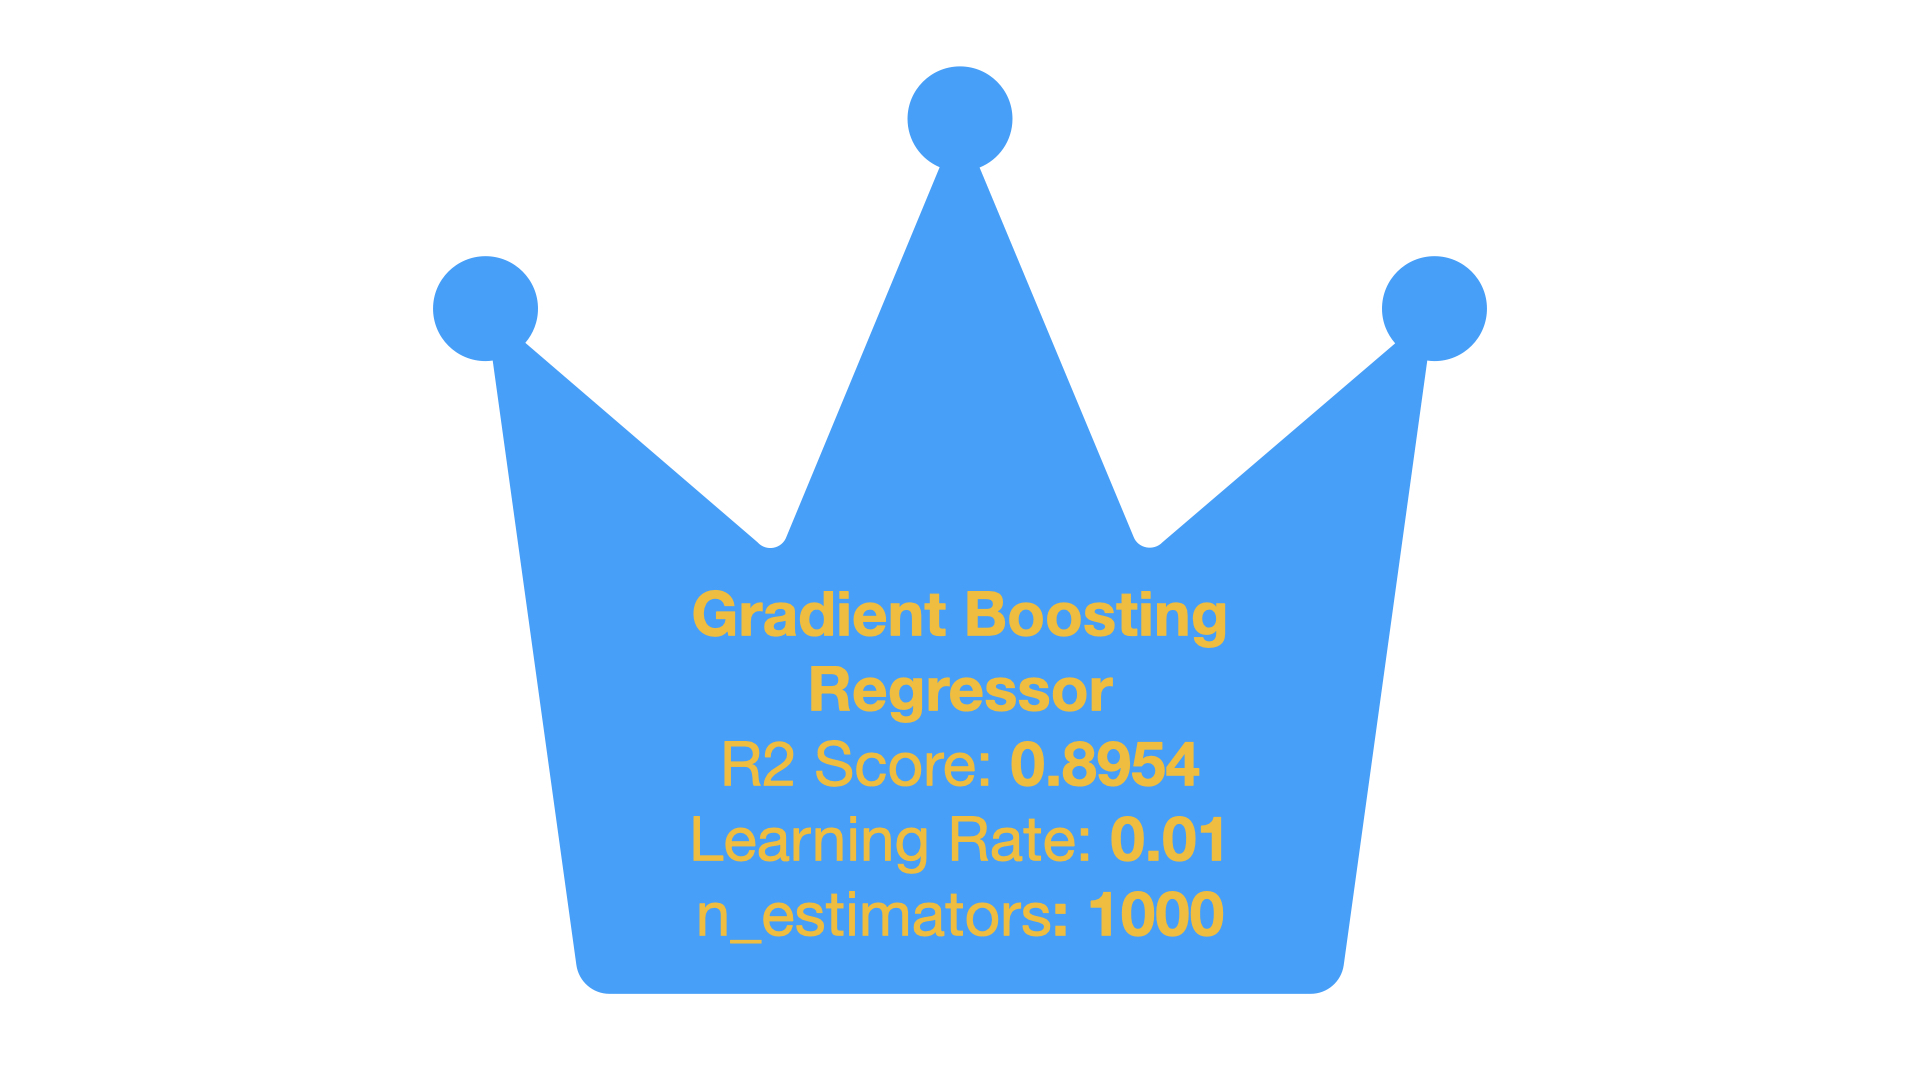

In [ ]:
#backup for presentation
winner = GradientBoostingRegressor(learning_rate= 0.01, max_depth= 6, n_estimators= 1500, subsample= 0.5)
winner.fit(X_train, y_train)
y_pred = winner.predict(X_test)
r2 = r2_score(y_test, y_pred)

print('**************')
print('Gradient Boosting Regressor')
print('r2 score %s' % r2)
print('**************')
print()

**************
Gradient Boosting Regressor
r2 score 0.8994913616639515
**************



Text(0.5, 1.0, 'Feature Importance (MDI)')

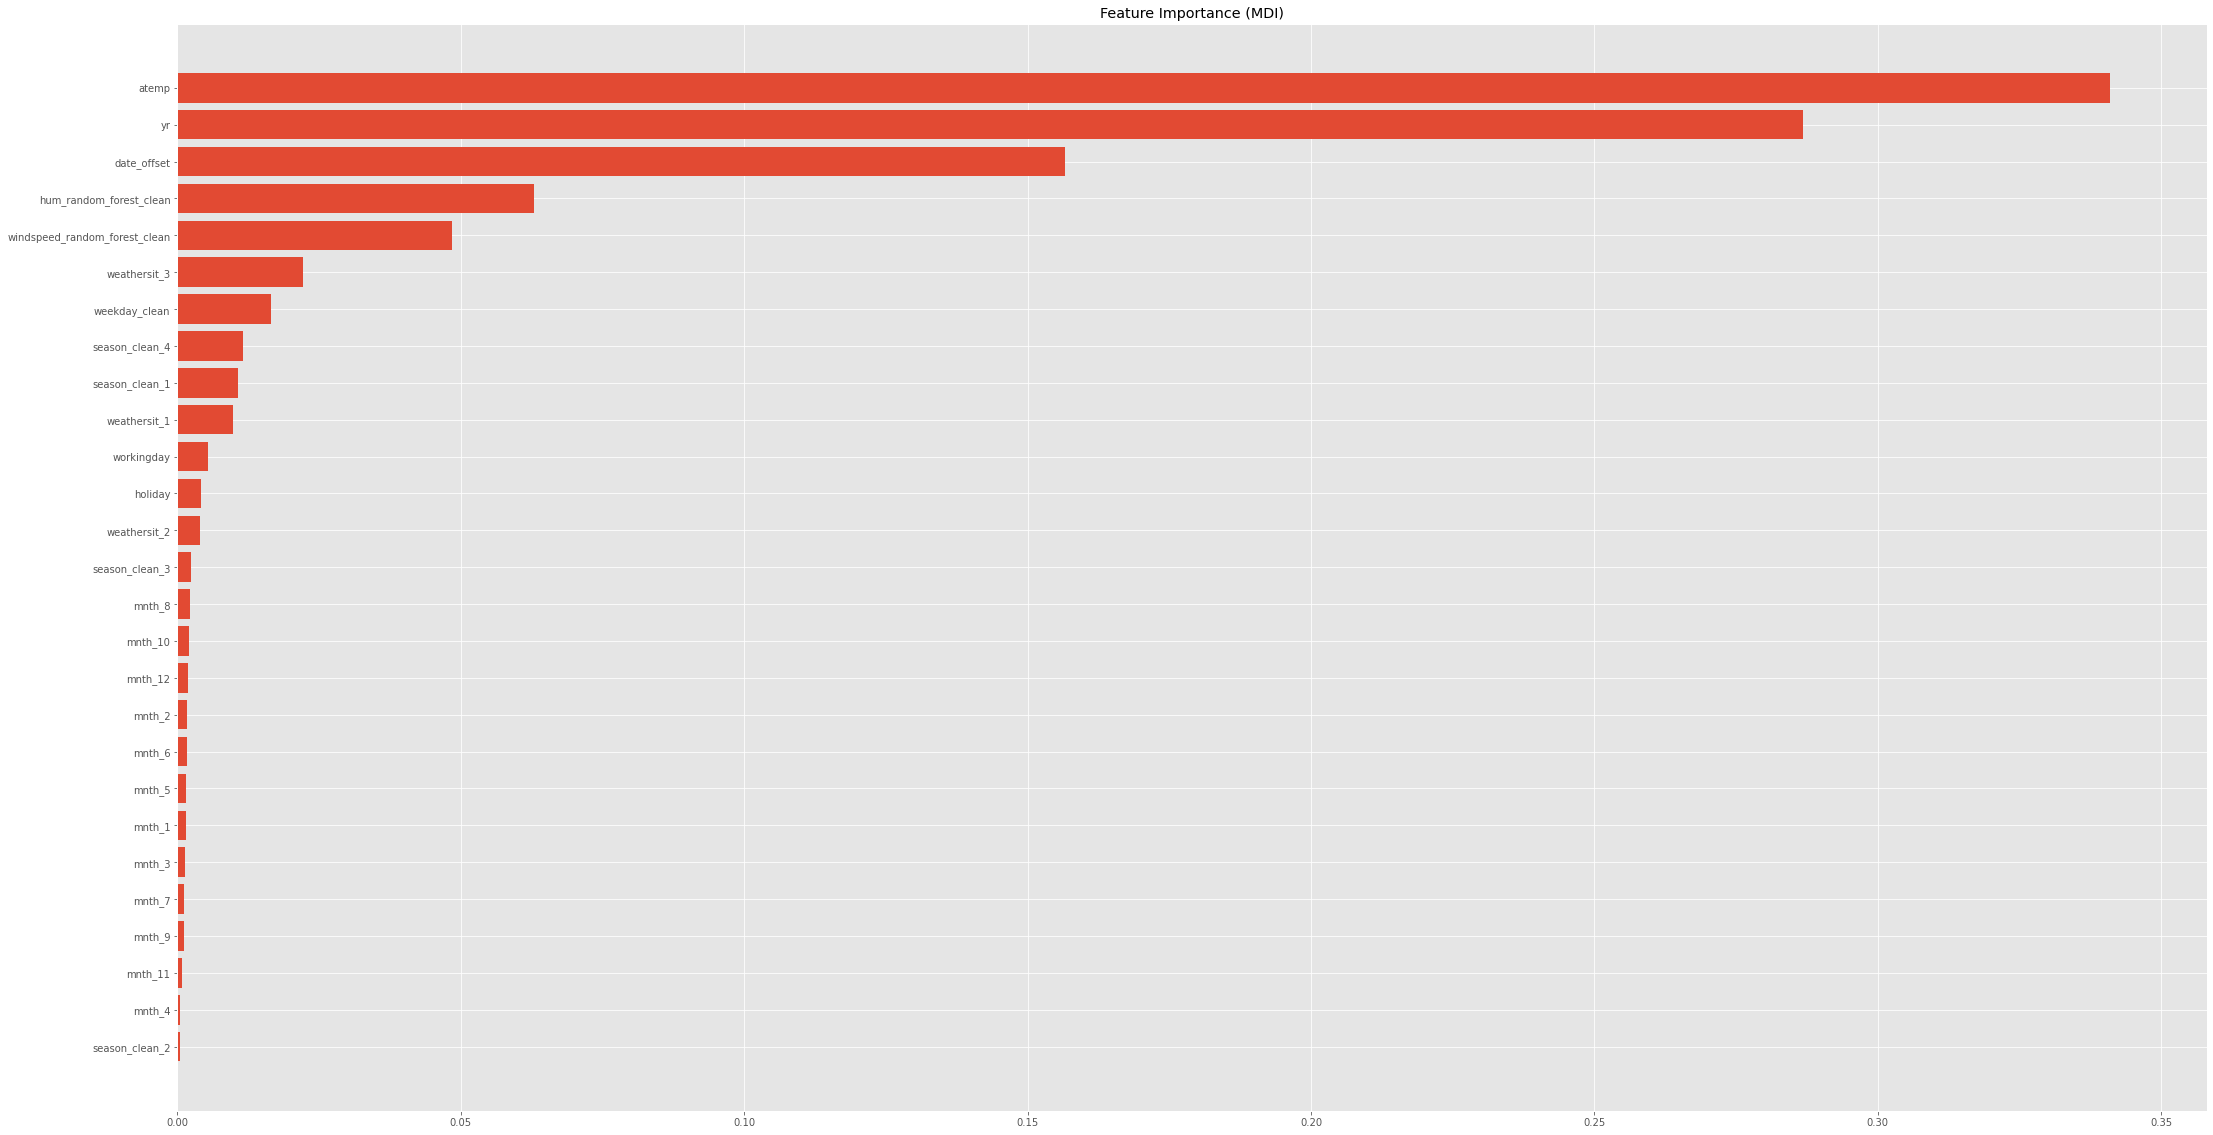

In [ ]:
feature_importance = winner.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize=(80, 20))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(cols_to_consider_manual)[sorted_idx])
plt.title('Feature Importance (MDI)')

Die Feature Importance wird berechnet als die Abnahme der Knotenverunreinigung, gewichtet mit der Wahrscheinlichkeit, diesen Knoten zu erreichen. Die Knotenwahrscheinlichkeit kann durch die Anzahl der Proben, die den Knoten erreichen, geteilt durch die Gesamtzahl der Proben, berechnet werden. Je höher der Wert, desto wichtiger ist das Merkmal.